<a href="https://colab.research.google.com/github/rasecresende/CS166/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Network

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats as sts
import random
import heapq
from types import GeneratorType
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra
from networkx.algorithms.shortest_paths.generic import shortest_path
from typing_extensions import ParamSpecKwargs
import seaborn as sns
sns.set() 

In [2]:
def initialize_network():
    """
    This function sets up the network structure
    and attributes
    """
    
    #create network
    G = nx.random_regular_graph(3,20)

    # set the length between each node
    for i,j in G.edges():
        G[i][j]['length'] = round(10*random.uniform(1,10),2)

    for node in G.nodes():
      #assigns a 15% chance of a node being a drop-off station
      if random.uniform(0,1) >= 0.15:
        G.nodes[node]['drop-off'] = False
      else:
        G.nodes[node]['drop-off'] = True

    #assume that we can't drop trash at HQ
    G.nodes[0]['drop-off'] = False

    return G 

In [3]:
def delete_edges(network):
  '''
  Delete edges at random to make
  the network more organic
  '''
  for edge in network.edges():
    if random.random() < 0.15:
      network.remove_edge(*edge)

def create_network():
  '''
  Creates a random network
  '''

  worked = False
  # initalizes a new network until we have no isolated node
  while worked is False:
    G = initialize_network()
    delete_edges(G)

    try:
      nx.approximation.traveling_salesman_problem(G, weight='length')
    except:
      print('There are unconnected edges, running again...')
      continue
    else:
      print('Successfully removed edges')
      worked = True
      return G

In [4]:
def draw(network):
  '''
  This function takes a network
  and plots the nodes along edge weights
  '''
  #set color scheme, with orange being drop-off stations
  #red is the HQ
  color_map = []
  for node in network.nodes(): 
    if network.nodes[node]['drop-off'] == True:
      color_map.append("orange")
    elif network.nodes[node] is network.nodes[0] :
      color_map.append('red')
    else:
      color_map.append("skyblue")
  

  pos = nx.kamada_kawai_layout(network)
  nx.draw(network, pos=pos, with_labels=True, node_size = 1000, node_color = color_map)
  labels = nx.get_edge_attributes(network,'length')
  nx.draw_networkx_edge_labels(network, pos=pos, edge_labels = labels)
  plt.savefig('fig.png')
  plt.show()

Successfully removed edges


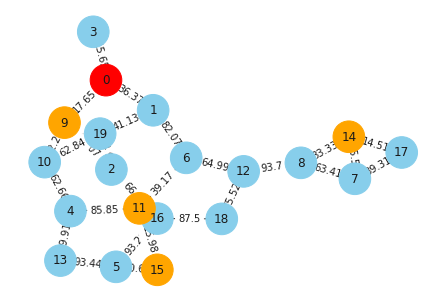

In [5]:
G = create_network()
draw(G)

# Building Simulation

In [6]:
from networkx.algorithms import shortest_paths
class Truck (object):
  def __init__(self):
    self.depot_node = 0 #home node
    self.fill = 0 #how much trash it's carrying
    self.travelled = 0 #how much it travelled
    self.tank = 1000 #amount of fuel on tank
    self.current_node = self.depot_node # current node, intialized at hq
    self.visited = 0 #nodes visited by truck


class Network ():
  def __init__(self, hq_drop=False, printing=False):
    self.hq_drop = hq_drop #whether we can drop-off waste at the station or not
    self.printing = printing #sets whether to show test cases or not
    self.g = G #networkx graph
    self.g.pos = nx.kamada_kawai_layout(self.g)
    self.time = 0 #keeps track of time passing
    self.truck = Truck() #instantiates truck object
    self.fuel_used = 1000 #keeps track of all fuel refilled

    #initialize trash attribute
    for node in self.g.nodes:
      self.g.nodes[node]['trash'] = sts.truncnorm.rvs(0, 1000, loc=300, scale=100)
    
    #add HQ as drop-off if requested
    if self.hq_drop:
      self.g.nodes[self.truck.depot_node]['drop-off'] = True

    # get list of drop-off stations
    self.drop_stations = [i[0] for i in nx.get_node_attributes(self.g, "drop-off").items() if i[True]]

    #there is no trash produced if the node is a drop-off station
    for node in self.drop_stations:
      self.g.nodes[node]['trash'] = 0

    # the HQ never produces trash
    self.g.nodes[self.truck.depot_node]['trash'] = 0

    #creates a list of all the stations that we have to visit before
    #the simulation ends
    self.to_visit = []
    for node in self.g.nodes:
      if self.g.nodes[node]['trash'] > 0:
        self.to_visit.append(node)

  def shortest_path(self, nodes, current_node):
    '''
    Given a set of nodes, calculate the overall shortest path
    from the current node to all other available ones
    '''
    paths = {}
    for node in nodes:
      if current_node == node:
        pass # prevents from travelling to itself
      else:
        path = nx.shortest_path(self.g, source = current_node,
                                target=node, weight = 'length')
        path_length = nx.shortest_path_length(self.g, source = current_node,
                                target=node, weight = 'length')
          
        paths[path_length] = path # stores the route and length as dictionary
        
    return paths


  def check_fuel(self, truck, distance, original_paths):
    '''
    Function to verify if the truck can proceed with
    the route or has to go back to refuel
    '''

    gas_used = 8*distance #8 units of gas per 1 unit travelled
    if gas_used <= truck.tank:
      truck.tank -= gas_used
      self.fuel_used += gas_used #update the amount of gas we have to pay for
      return original_paths #move the intended way
    
    # if there is no gas left, find path to HQ  
    else:
      if self.printing:
        print('Refueling the truck! ⛽')
      fuel_paths = {}
      path = nx.shortest_path(self.g, source = truck.current_node,
                              target=truck.depot_node, weight = 'length')
      path_length = nx.shortest_path_length(self.g, source = truck.current_node,
                              target=truck.depot_node, weight = 'length')
      fuel_paths[path_length] = path
      return fuel_paths #move to hq if not enough fuel


  def trash_collection(self, truck):
    '''
    Check if truck can pick up the trash and update fill
    attribute. If trash is filled, pick what we can and move
    to the nearest drop-off station
    '''

    amount = self.g.nodes[truck.current_node]['trash']
    available = 1000 - truck.fill # truck can only carry 100kg

    if amount > available:
      truck.fill = 1000 # fill what we can
      self.g.nodes[truck.current_node]['trash'] = amount - available

      #add time based on the amount of trash we pick up
      self.time += abs(available*sts.norm.rvs(loc=0, scale=0.1))/10

    elif amount == 0 : #pass if there is nothing to pick
      pass

    else:
      truck.fill += amount # pick everything up
      try:
        self.to_visit.remove(truck.current_node) # remove node from list
      except:
        pass

      #add time the same way as above
      self.time += abs(amount/20*sts.norm.rvs(loc=0, scale=0.1))
  

  def check_trash(self, truck):
    '''
    Check if the truck is filled and give coordinates
    for nearest drop-off station
    '''
    if truck.fill == 1000:
      drop_paths = self.shortest_path(self.drop_stations, truck.current_node)
      return drop_paths

  def update_greedy(self):
    '''
    Updates the function by 1 time step using a greedy approach
    '''
    # Step 1: Collect trash
    self.trash_collection(self.truck)

    # Step 2: Check if we need to drop trash off
    if self.truck.fill == 1000:
      paths = self.check_trash(self.truck)
      distance = min(paths)
      self.truck.fill = 0
      if self.printing:
        print('Emptying the truck!🗑️')

    else:
      # Step 3: If not, set the next path of the truck as the one closest
      # to the current node
      paths = self.shortest_path(self.to_visit, self.truck.current_node)
      distance = min(paths) # gets the shortest next path

      # Step 4: Check fuel to see if possible to travel
      if self.truck.current_node != self.truck.depot_node:
        paths = self.check_fuel(self.truck, distance, paths)
        distance = min(paths)
      else:
        self.truck.tank = 1000

    # Step 5: Travel to new node
    next_stop = paths[distance][-1]
    self.truck.travelled += distance
    self.truck.current_node = next_stop


  def update_tsp(self):
    '''
    Implement a solution of the Travelling Salesman Problem
    from the NetworkX library
    '''
    # Step 1: Calculate the optimal route so as to minimize distance
    # and still visit all of the nodes
    tsp = nx.approximation.traveling_salesman_problem
    optimal_path = tsp(self.g, weight='length')

    if self.truck.visited != len(optimal_path):
      optimal_path = optimal_path[self.truck.visited:]
      next_stop = optimal_path[0]
      paths = {}
      path_length = nx.shortest_path_length(self.g, source = self.truck.current_node,
                                  target=next_stop, weight = 'length')
      
      paths[path_length] = [self.truck.current_node, optimal_path[0]]
      distance = path_length

    
      # Step 1: Collect trash
      self.trash_collection(self.truck)

      # Step 2: Check if we need to drop trash off
      if self.truck.fill == 1000:
        paths = self.check_trash(self.truck)
        distance = min(paths)
        self.truck.fill = 0
        if self.printing:
          print('Emptying the truck!🗑️')

      # Step 4: Check fuel to see if possible to travel
      if self.truck.current_node == self.truck.depot_node:
        self.truck.tank = 1000
      else:
        gas_used = 8*distance #8 units of gas per 1 unit travelled
        if gas_used <= self.truck.tank:
          self.truck.tank -= gas_used
          self.fuel_used += gas_used
        else:
          paths = {}
          path = nx.shortest_path(self.g, source = self.truck.current_node,
                                  target=self.truck.depot_node, weight = 'length')
          path_length = nx.shortest_path_length(self.g, source = self.truck.current_node,
                                  target=self.truck.depot_node, weight = 'length')
          paths[path_length] = path
          distance = min(paths)
          next_stop = self.truck.depot_node

      # update attributes
      self.truck.travelled += distance

      self.truck.current_node = next_stop
      self.truck.visited += 1

    # if by the end of completing the route the truck has not collected
    # all of the trash, shift back to a greedy approach
    else:
      self.update_greedy()
      

  def run_simulation(self, update_method='greedy'):
    '''
    Run the simulation and print relevant metrics
    '''
    if self.printing:
      print('🚚💨')
      print('STARTING SIMULATION - LEAVING HQ')
      print()
    if update_method == 'greedy':
      while len(self.to_visit) > 1:
        self.update_greedy()
        if self.printing:
          print('current node:', self.truck.current_node)
          print('trash at node:', round(self.g.nodes[self.truck.current_node]['trash'],2))
          print('farms left to clean:', self.to_visit)
          print('current fuel on tank:', round(self.truck.tank,2))
          print('current fill:', round(self.truck.fill,2))
          print('fuel used so far:', round(self.fuel_used,2))
          print()
      if self.printing:
        print('The simulation has finished ✔️ ')

    if update_method == 'tsp':
      while len(self.to_visit) > 1:
        self.update_tsp()
        if self.printing:
          print('current node:', self.truck.current_node)
          print('trash at node:', round(self.g.nodes[self.truck.current_node]['trash'],2))
          print('farms left to clean:', self.to_visit)
          print('current fuel on tank:', round(self.truck.tank,2))
          print('current fill:', round(self.truck.fill,2))
          print('fuel used so far:', round(self.fuel_used,2))
          print()
      if self.printing:
        print('The simulation has finished ✔️ ')

  def get_metrics(self):
    '''
    Retrieves all of the key metrics for comparing
    different strategies
    '''
    # assumes that each truck travels at 110km/h
    self.time += self.truck.travelled/110
    return self.time, self.fuel_used

# Running Simulation

In [7]:
# Test case demonstrating the simulation
test_case = Network(False, printing=True)
test_case.run_simulation()

🚚💨
STARTING SIMULATION - LEAVING HQ

current node: 3
trash at node: 317.48
farms left to clean: [17, 5, 13, 1, 6, 3, 8, 2, 19, 4, 16, 18, 10, 7, 12]
current fuel on tank: 1000
current fill: 0
fuel used so far: 1000

current node: 1
trash at node: 393.4
farms left to clean: [17, 5, 13, 1, 6, 8, 2, 19, 4, 16, 18, 10, 7, 12]
current fuel on tank: 583.84
current fill: 317.48
fuel used so far: 1416.16

current node: 19
trash at node: 377.86
farms left to clean: [17, 5, 13, 6, 8, 2, 19, 4, 16, 18, 10, 7, 12]
current fuel on tank: 254.8
current fill: 710.88
fuel used so far: 1745.2

Emptying the truck!🗑️
current node: 9
trash at node: 0
farms left to clean: [17, 5, 13, 6, 8, 2, 19, 4, 16, 18, 10, 7, 12]
current fuel on tank: 254.8
current fill: 0
fuel used so far: 1745.2

current node: 10
trash at node: 501.14
farms left to clean: [17, 5, 13, 6, 8, 2, 19, 4, 16, 18, 10, 7, 12]
current fuel on tank: 77.04
current fill: 0
fuel used so far: 1922.96

Refueling the truck! ⛽
current node: 0
trash a

In [8]:
def results(trials, hq_drop, update_method):
  '''
  Run simulation over multiple trials
  and get time and fuel measurements
  '''
  time = []
  fuel = []

  for i in range(trials):
    sim = Network(hq_drop)
    sim.run_simulation(update_method)
    m1, m2 = sim.get_metrics()
    time.append(m1)
    fuel.append(m2)
  
  return time, fuel

In [10]:
# Greedy approach with no hq_drop
t1, f1 = results(1000, False, 'greedy')

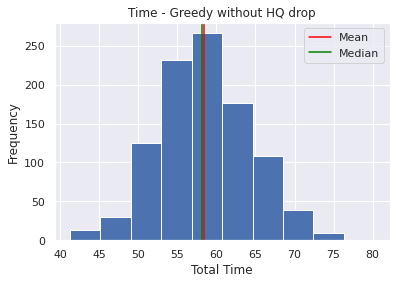

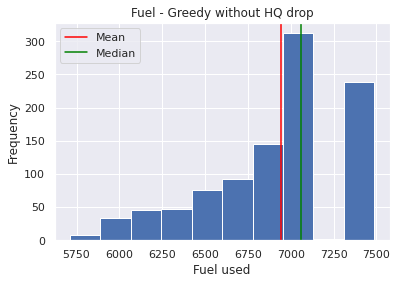

In [11]:
plt.figure()
plt.hist(t1)
plt.axvline(np.mean(t1), label='Mean', color='red')
plt.axvline(np.median(t1), label='Median', color='green')
plt.title('Time - Greedy without HQ drop')
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('fig2.png')
plt.show()

plt.hist(f1)
plt.axvline(np.mean(f1), label='Mean', color='red')
plt.axvline(np.median(f1), label='Median', color='green')
plt.title('Fuel - Greedy without HQ drop')
plt.xlabel('Fuel used')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('fig3.png')
plt.show()

In [12]:
# Greedy approach with hq_drop
t2, f2 = results(1000, True, 'greedy')

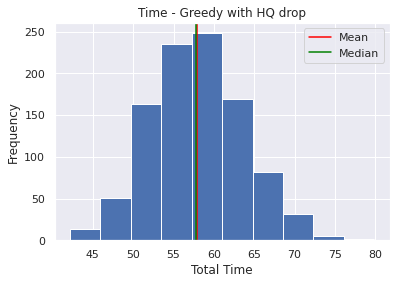

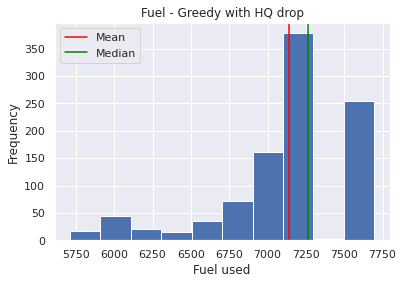

In [18]:
plt.figure()
plt.hist(t2)
plt.axvline(np.mean(t2), label='Mean', color='red')
plt.axvline(np.median(t2), label='Median', color='green')
plt.title('Time - Greedy with HQ drop')
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('fig4.png')
plt.show()

plt.hist(f2)
plt.axvline(np.mean(f2), label='Mean', color='red')
plt.axvline(np.median(f2), label='Median', color='green')
plt.title('Fuel - Greedy with HQ drop')
plt.xlabel('Fuel used')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('fig5.png')
plt.show()

In [14]:
# TSP approach without hq_drop
t3, f3 = results(1000, False, 'tsp')

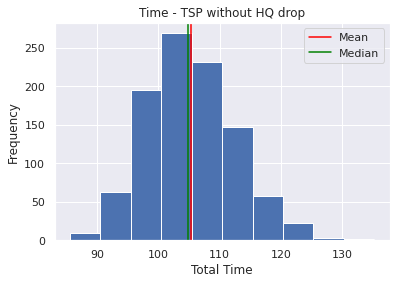

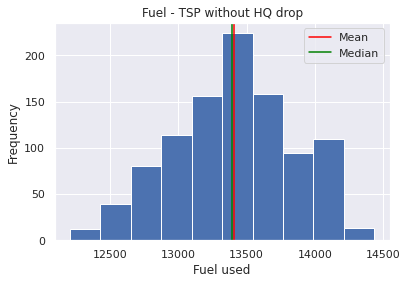

In [19]:
plt.figure()
plt.hist(t3)
plt.axvline(np.mean(t3), label='Mean', color='red')
plt.axvline(np.median(t3), label='Median', color='green')
plt.title('Time - TSP without HQ drop')
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('fig6.png')
plt.show()

plt.hist(f3)
plt.axvline(np.mean(f3), label='Mean', color='red')
plt.axvline(np.median(f3), label='Median', color='green')
plt.title('Fuel - TSP without HQ drop')
plt.xlabel('Fuel used')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('fig7.png')
plt.show()

In [16]:
# TSP approach with hq_drop
t4, f4 = results(1000, True, 'tsp')

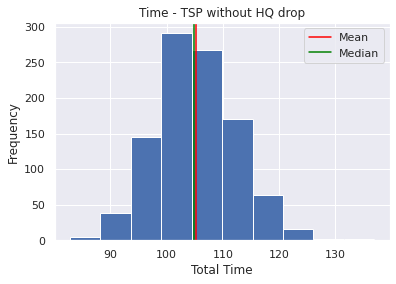

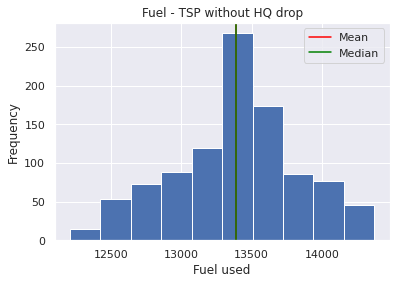

In [20]:
plt.figure()
plt.hist(t4)
plt.axvline(np.mean(t4), label='Mean', color='red')
plt.axvline(np.median(t4), label='Median', color='green')
plt.title('Time - TSP without HQ drop')
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('fig8.png')
plt.show()

plt.hist(f4)
plt.axvline(np.mean(f4), label='Mean', color='red')
plt.axvline(np.median(f4), label='Median', color='green')
plt.title('Fuel - TSP without HQ drop')
plt.xlabel('Fuel used')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('fig9.png')
plt.show()

In [37]:
def calculate_metrics(t,f):
  print('μ:', np.mean(t))
  print('C.I.:', np.quantile(t, [0.025, 0.975]))
  print()
  print('μ:', np.mean(f))
  print('C.I.:', np.quantile(f, [0.025, 0.975]))

In [38]:
calculate_metrics(t1,f1)

μ: 58.43970351064078
C.I.: [48.10620647 70.32425318]

μ: 6942.914000000001
C.I.: [6024.72 7487.52]


In [39]:
calculate_metrics(t2,f2)

μ: 57.962478226305706
C.I.: [47.69660411 69.31962976]

μ: 7138.829360000001
C.I.: [6024.72 7696.08]


In [40]:
calculate_metrics(t3,f3)

μ: 105.3664265084098
C.I.: [ 92.52986503 120.73690592]

μ: 13405.738720000005
C.I.: [12524.72 14183.28]


In [41]:
calculate_metrics(t4,f4)

μ: 105.27585873848157
C.I.: [ 92.45510748 119.713117  ]

μ: 13388.376400000005
C.I.: [12484.026 14183.28 ]
